In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

In [3]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [4]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)

In [5]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [44]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 250
batch_size = 1024

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 5
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

    def model(self,optimizer = "RMSProp", score = 'acc', loss = "mse", epochs = 250, dim = 5):
        encoding_dim = dim
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=score) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 3225      
_________________________________________________________________
dense_36 (Dense)             (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.2800 - mape: 109190.1641 - val_loss: 0.2810 - val_mape: 183850.5000
Epoch 2/250
1/1 [==============================] - 0s 56ms/step - loss: 0.2761 - mape: 115892.2969 - val_loss: 0.2699 - val_mape: 185415.0000
Epoch 3/250
1/1 [==============================] - 0s 75ms/step - loss: 0.2653 - mape: 118001.2969 - val

1/1 [==============================] - 0s 43ms/step - loss: 0.0630 - mape: 726426.0000 - val_loss: 0.0641 - val_mape: 1010146.0000
Epoch 54/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0611 - mape: 736265.0625 - val_loss: 0.0623 - val_mape: 1023444.1875
Epoch 55/250
1/1 [==============================] - 0s 103ms/step - loss: 0.0593 - mape: 746003.5000 - val_loss: 0.0605 - val_mape: 1036636.0000
Epoch 56/250
1/1 [==============================] - 0s 60ms/step - loss: 0.0576 - mape: 755640.1875 - val_loss: 0.0588 - val_mape: 1049719.6250
Epoch 57/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0559 - mape: 765175.6250 - val_loss: 0.0571 - val_mape: 1062693.2500
Epoch 58/250
1/1 [==============================] - 0s 84ms/step - loss: 0.0542 - mape: 774658.1875 - val_loss: 0.0554 - val_mape: 1075554.7500
Epoch 59/250
1/1 [==============================] - 0s 63ms/step - loss: 0.0526 - mape: 784035.1250 - val_loss: 0.0538 - val_mape: 1088301.7500
Epoc

Epoch 110/250
1/1 [==============================] - 0s 58ms/step - loss: 0.0133 - mape: 1009387.1875 - val_loss: 0.0155 - val_mape: 1534297.2500
Epoch 111/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0131 - mape: 1023078.3750 - val_loss: 0.0153 - val_mape: 1528473.7500
Epoch 112/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0128 - mape: 1008087.1875 - val_loss: 0.0151 - val_mape: 1542978.8750
Epoch 113/250
1/1 [==============================] - 0s 59ms/step - loss: 0.0126 - mape: 1022419.8750 - val_loss: 0.0149 - val_mape: 1535626.6250
Epoch 114/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0124 - mape: 1004131.6250 - val_loss: 0.0147 - val_mape: 1551412.7500
Epoch 115/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0122 - mape: 1021334.8125 - val_loss: 0.0145 - val_mape: 1542043.0000
Epoch 116/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0120 - mape: 998422.0000 - val_loss: 0.0144 - va

Epoch 166/250
1/1 [==============================] - 0s 54ms/step - loss: 0.0088 - mape: 970731.3125 - val_loss: 0.0115 - val_mape: 1648913.6250
Epoch 167/250
1/1 [==============================] - 0s 85ms/step - loss: 0.0089 - mape: 1028718.3750 - val_loss: 0.0114 - val_mape: 1586536.1250
Epoch 168/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0088 - mape: 969970.1875 - val_loss: 0.0115 - val_mape: 1649714.2500
Epoch 169/250
1/1 [==============================] - 0s 125ms/step - loss: 0.0089 - mape: 1028329.3750 - val_loss: 0.0114 - val_mape: 1586337.7500
Epoch 170/250
1/1 [==============================] - 0s 55ms/step - loss: 0.0088 - mape: 969211.0000 - val_loss: 0.0115 - val_mape: 1650426.6250
Epoch 171/250
1/1 [==============================] - 0s 62ms/step - loss: 0.0089 - mape: 1027911.6250 - val_loss: 0.0114 - val_mape: 1586123.1250
Epoch 172/250
1/1 [==============================] - 0s 61ms/step - loss: 0.0087 - mape: 968453.0000 - val_loss: 0.0114 - val_

1/1 [==============================] - 0s 75ms/step - loss: 0.0084 - mape: 949887.8125 - val_loss: 0.0111 - val_mape: 1653616.2500
Epoch 223/250
1/1 [==============================] - 0s 75ms/step - loss: 0.0085 - mape: 1013415.3750 - val_loss: 0.0111 - val_mape: 1578600.7500
Epoch 224/250
1/1 [==============================] - 0s 70ms/step - loss: 0.0084 - mape: 949182.6875 - val_loss: 0.0111 - val_mape: 1653470.5000
Epoch 225/250
1/1 [==============================] - 0s 56ms/step - loss: 0.0085 - mape: 1012838.5000 - val_loss: 0.0111 - val_mape: 1578272.3750
Epoch 226/250
1/1 [==============================] - 0s 69ms/step - loss: 0.0083 - mape: 948481.1875 - val_loss: 0.0111 - val_mape: 1653319.2500
Epoch 227/250
1/1 [==============================] - 0s 99ms/step - loss: 0.0085 - mape: 1012265.3750 - val_loss: 0.0110 - val_mape: 1577944.6250
Epoch 228/250
1/1 [==============================] - 0s 78ms/step - loss: 0.0083 - mape: 947783.6875 - val_loss: 0.0111 - val_mape: 1653163.0

In [45]:
simple_autoencoder().reduced_dim()

,0,1,2,3,4
0,-0.858245,-0.595300,0.500048,-0.834610,0.553241
1,-0.724738,-0.678169,0.142439,-0.888083,0.178643
2,-0.723200,-0.607522,0.142859,-0.833158,0.169388
3,-0.716938,-0.546369,0.187087,-0.858593,0.521402
4,-0.687886,-0.656243,0.324332,-0.772718,-0.008808


In [48]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_mape"])
    plt.title("MAPE")

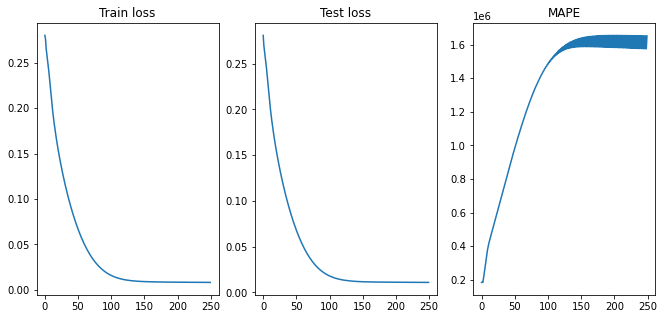

In [49]:
# Loss vs Epoch
plot_history(history)

## Hyperparameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(simple_autoencoder().model, verbose=1, batch_size=10, epochs=10)

#define the grid search parameters
dim = [5, 10, 15, 20]
loss = ['mae','mse','mape','mean_squared_logarithmic_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
score = ['acc', 'mae','mse','mape']

param_grid = dict(optimizer=optimizer,score = score, loss = loss, dim = dim)

In [ ]:
random_search = RandomizedSearchCV(estimator=model_regressor, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

random_best_parameters = random_search.best_params_
random_best_accuracy = random_search.best_score_

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_127 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_128 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1345 - mape: 222016.7157
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0965 - mape: 480987.6922
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0834 - mape: 547027.9186
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0802 - mape: 53

8/8 [==============================] - 0s 1ms/step - loss: 0.4575 - acc: 0.0000e+00
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_145 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_146 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.5015 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4992 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4957 - acc: 0.0000e+00
Epoch 4/1

32/32 [==============================] - 1s 2ms/step - loss: 0.1865 - acc: 1.8939e-04
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0140 - acc: 0.0050
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.1652
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - acc: 0.1709
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0105 - acc: 0.1595
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0103 - acc: 0.1590
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.1824
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0106 - acc: 0.1547
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.1579
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0075 - acc: 0.2125
Model: "model_83"
____________________________________________________________

32/32 [==============================] - 1s 5ms/step - loss: 0.0941 - mse: 0.2716
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0713 - mse: 0.2357
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0677 - mse: 0.2204
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0577 - mse: 0.1959
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0506 - mse: 0.1845
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0498 - mse: 0.1801
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0461 - mse: 0.1703
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.1591
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0419 - mse: 0.1605
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0399 - mse: 0.1587
Model: "model_88"
________________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4448 - mape: 322340.6046
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1758 - mape: 994839.6837
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0807 - mape: 1402518.1316
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0730 - mape: 1381301.1780
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0718 - mape: 1307284.5360
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0679 - mape: 1397499.5720
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0665 - mape: 1076311.0549
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0662 - mape: 1182761.9943
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0653 - mape: 1119640.6946
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0598 - mape: 754494.1250
Model: "model_9

32/32 [==============================] - 0s 4ms/step - loss: 0.0232 - acc: 0.0030
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0156 - acc: 0.0346
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0121 - acc: 0.1853
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 0.2129
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.1885
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - acc: 0.1749
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0085 - acc: 0.1625
Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_211 (Dense)            (None, 5)                 3225      
____________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.0855 - mape: 816770.0909
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0647 - mape: 1070409.9242
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0587 - mape: 968582.2822
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0520 - mape: 1061386.7064
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0473 - mape: 965872.1799
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0429 - mape: 1086094.2841
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0397 - mape: 1070027.1837
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0383 - mape: 1185465.5682
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0364 - mape: 990607.6364
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0352 - mape: 676376.4375
Model:

32/32 [==============================] - 1s 4ms/step - loss: 151586.2654 - mape: 151586.2654
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 127811.4555 - mape: 127811.4631
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 96872.6977 - mape: 96872.6977
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 93718.2099 - mape: 93718.2099
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 94899.9091 - mape: 94899.9079
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 69753.9990 - mape: 69753.9990
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 75317.4055 - mape: 75317.4055
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 75409.7573 - mape: 75409.7573
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 78258.2608 - mape: 78258.2608
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 1295096.0000 - map

32/32 [==============================] - 1s 2ms/step - loss: 0.2118 - mae: 0.4032
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0200 - mae: 0.1002
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0106 - mae: 0.0717
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.0687
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0699
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0094 - mae: 0.0669
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0086 - mae: 0.0638
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0088 - mae: 0.0648
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0087 - mae: 0.0643
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0704
Model: "model_129"
_______________________________________________________________

32/32 [==============================] - 0s 4ms/step - loss: 0.0863 - mae: 0.0863
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0697 - mae: 0.0697
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0708 - mae: 0.0708
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0693 - mae: 0.0693
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - mae: 0.0706
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.0686
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0698 - mae: 0.0698
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.0696
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0579 - mae: 0.0579
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)  

32/32 [==============================] - 1s 2ms/step - loss: 0.1011 - acc: 4.9265e-04
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0723 - acc: 0.0027
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0695 - acc: 0.0114
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0642 - acc: 0.0062
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0556 - acc: 0.0154
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0502 - acc: 0.0165
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0457 - acc: 0.0245
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0434 - acc: 0.0147
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0421 - acc: 0.0086
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0386 - acc: 0.0125
Model: "model_143"
___________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4941 - mae: 0.4941
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4895 - mae: 0.4895
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4849 - mae: 0.4849
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4788 - mae: 0.4788
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4794 - mae: 0.4794
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4662 - mae: 0.4662
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4550 - mae: 0.4550
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4580 - mae: 0.4580
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4566 - mae: 0.4566
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4446 - mae: 0.4446
Model: "model_148"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 2411418.6117 - mae: 6432.4154
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 104171066088.7273 - mae: 19617.2515
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 1608362596.0758 - mae: 9896.8403
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 86452280847.5152 - mae: 21029.6278
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 3282053007.5152 - mae: 8634.6092
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 76857753103.5152 - mae: 22192.4449
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 3170874559.6212 - mae: 7839.4632
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 99596780388.8485 - mae: 19548.8697
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 1544635009.9394 - mae: 9384.7519
Epoch 10/10
8/8 [==============================] - 0s 4ms/st

32/32 [==============================] - 1s 2ms/step - loss: 1928844.9898 - mse: 86066102.0169
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 43065172216.2424 - mse: 196991568.9697
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 512382958.5455 - mse: 73758450.9242
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 55353575113.6970 - mse: 176049083.8788
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 496708889.5606 - mse: 67721849.0076
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 49921017607.7576 - mse: 184289907.6364
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 671553774.4167 - mse: 57504639.5758
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 48351825857.9394 - mse: 186002647.2727
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 561728825.2121 - mse: 61481554.1364
Epoch 10/10
8/8 [============

32/32 [==============================] - 1s 2ms/step - loss: 0.1077 - mse: 0.2591
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0761 - mse: 0.2099
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0746 - mse: 0.2062
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0739 - mse: 0.2018
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0705 - mse: 0.1903
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0632 - mse: 0.1735
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0571 - mse: 0.1577
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0537 - mse: 0.1479
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0507 - mse: 0.1388
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0446 - mse: 0.1208
Model: "model_175"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1450 - mae: 0.5047
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1424 - mae: 0.5044
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.5009
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.4965
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.4983
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1327 - mae: 0.4940
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1314 - mae: 0.4930
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1301 - mae: 0.4921
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1285 - mae: 0.4900
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1253 - mae: 0.4810
Model: "model_180"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1226 - mape: 290756.3880
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0924 - mape: 410291.9953
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0854 - mape: 503547.4422
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0841 - mape: 576786.6657
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0825 - mape: 578065.9356
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0729 - mape: 609279.4261
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0624 - mape: 797132.5360
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0589 - mape: 667312.5568
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0573 - mape: 850674.3845
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0529 - mape: 1538633.2500
Model: "model_185"
__

8/8 [==============================] - 0s 2ms/step - loss: 0.0449 - mape: 1250345.8750
Model: "model_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_190 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_377 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_378 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1046 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0724 - acc: 0.0027
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0718 - acc: 0.0020
Epoch 4/10
32

32/32 [==============================] - 1s 5ms/step - loss: 0.2211 - mape: 322611.0646
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0288 - mape: 1040345.5322
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0109 - mape: 1141813.6856
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0094 - mape: 909570.7652
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mape: 1080280.2121
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - mape: 912594.0568
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0091 - mape: 1094598.3977
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0088 - mape: 1030652.5170
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0086 - mape: 908116.8049
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - mape: 1638702.2500
Model: "model_19

32/32 [==============================] - 1s 1ms/step - loss: 0.5030 - mae: 0.5030
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4973 - mae: 0.4973
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5026 - mae: 0.5026
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4960 - mae: 0.4960
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4934 - mae: 0.4934
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4927 - mae: 0.4927
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4885 - mae: 0.4885
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4873 - mae: 0.4873
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4814 - mae: 0.4814
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4829 - mae: 0.4829
Model: "model_204"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 144118.1392 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 171604.1004 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 104596.4238 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 85413.1686 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 100150.4295 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 85620.6578 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 78788.9125 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 78288.5683 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 72734.4641 - acc: 0.0025
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 667601.1250 - acc: 0

32/32 [==============================] - 1s 2ms/step - loss: 1880174.9403 - acc: 0.0020
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 66188926665.6970 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 2161928934.0606 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 56700788549.8182 - acc: 0.0157
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 7230904972.8939 - acc: 0.0023
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 49362949585.4545 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 1568920351.3485 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 65834254460.1212 - acc: 9.5087e-04
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 2900645144.4470 - acc: 0.0013
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 1

32/32 [==============================] - 0s 6ms/step - loss: 0.0649 - mae: 0.2992
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.2852
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0622 - mae: 0.2835
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0623 - mae: 0.2837
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0622 - mae: 0.2822
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.2824
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0621 - mae: 0.2818
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0572 - mae: 0.2669
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0463 - mae: 0.2291
Model: "model_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_232 (InputLayer)  

32/32 [==============================] - 1s 2ms/step - loss: 0.2263 - mape: 434914.2595
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0256 - mape: 1504156.9299
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0110 - mape: 1215938.2311
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - mape: 1192886.5170
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mape: 1108600.9242
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mape: 1133798.3428
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0093 - mape: 1155931.9905
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mape: 1141891.3163
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0100 - mape: 1374856.4299
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0084 - mape: 789663.5000
Model: "model_

32/32 [==============================] - 1s 2ms/step - loss: 0.1257 - mae: 0.4697
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.3881
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0868 - mae: 0.3448
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0852 - mae: 0.3295
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0844 - mae: 0.3243
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.3122
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0641 - mae: 0.2754
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.2575
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.2461
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.2428
Model: "model_245"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1355 - mae: 0.4874
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.4050
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.3571
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.3361
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0827 - mae: 0.3263
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0828 - mae: 0.3227
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0823 - mae: 0.3197
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0819 - mae: 0.3174
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.3182
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0825 - mae: 0.3260
Model: "model_250"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2201 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0872 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0336 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0141 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.0639
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0091 - acc: 0.2060
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0086 - acc: 0.1891
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0096 - acc: 0.2193
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - acc: 0.1686
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0123 - acc: 0.1000
Model: "model_255"
_______________________________________________

In [ ]:
random_best_parameters

In [ ]:
random_best_accuracy